In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import statsmodels.api as sm
import tensorflow as tf
from datetime import timedelta

from sklearn.metrics import mean_squared_error
from sklearn.model_selection import KFold, TimeSeriesSplit, GridSearchCV
from sklearn import preprocessing
import keras.initializers
from keras.layers import Dense, Layer, LSTM, GRU, SimpleRNN, RNN
from keras.models import Sequential
from keras.models import load_model
from keras.regularizers import l1, l2
from keras.callbacks import EarlyStopping
from scikeras.wrappers import KerasClassifier, KerasRegressor

In [49]:
tf.config.list_physical_devices('GPU')

[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]

In [5]:
%matplotlib inline

# Univariate (5 Min Close Price)

In [1]:
# df = pd.read_csv('../data/coinbase.csv', index_col=0)
# df.index = pd.to_datetime(df.index, unit='s')

df = pd.read_csv('../data/BTC-USD.csv', index_col=0)
df.index = pd.to_datetime(df.index, infer_datetime_format=True)

target = "USD"

NameError: name 'pd' is not defined

In [146]:
df = df.dropna()
df['target_close'] = df['target_close'].pct_change()
df = df.dropna()

In [7]:
nof_missing_values = sum(np.isnan(df[target]))

print(nof_missing_values, 'observations are missing.')
print('This is {:.3f}% of the total.'.format(nof_missing_values*100/len(df)))

1662 observations are missing.
This is 0.368% of the total.


In [8]:
df = df.dropna()

nof_missing_values = sum(np.isnan(df[target]))

print('Now', nof_missing_values, 'observations are missing.')

Now 0 observations are missing.


### Stationarity
It is essential to determine whether the time series is "stationary". Informally, stationarity is when the auto-covariance is independent of time. Failure to establish stationarity will almost certainly lead to misinterpretation of model identification and diagnostic tests. Moreover, stationarity is decisive in characterizing the prediction problem and whether to use a more advanced architecture. In particular, we can expect a plain RNN to perform poorly if the data is non-stationary as the RNN exhibits fixed auto-covariance. 

We perform an Augmented Dickey-Fuller test to establish stationarity under the assumption that the time series has a constant bias but does not exhibit a time trend. In other words, we assume that the time series is already de-trended. 

If the stationarity test fails, even after first de-trending the time series, then one potential recourse is to simply take differences of time series and predict $\Delta y_t$.

The null hypothesis of the Augmented Dickey-Fuller is that there is a unit root, with the alternative that there is no unit root. If the p-value is above $(1-\alpha)$, then we cannot reject that there is a unit root. Note that a subset of the time series is used to reduce the memory requirements of the test. We use the first 200,000 samples to test for stationarity. While the test statistic is sensitive to the data size, the ADF test is always accepted at the 99\% level.

In [9]:
# check stationarity of target
# 1 min 56 sec
sample = df[target][:200000]

adf, p, usedlag, nobs, cvs, aic = sm.tsa.stattools.adfuller(sample)

In [10]:
print(f'ADF: {adf}\np-value: {p},\nN: {nobs}, \ncritical values: {cvs}')

ADF: -2.1035866500302576
p-value: 0.2430748394647394,
N: 199918, 
critical values: {'1%': -3.4303827103310676, '5%': -2.8615544575334875, '10%': -2.566777695225296}


close price is stationary when using differencing

In [11]:
adf_results_string = 'ADF: {}\np-value: {},\nN: {}, \ncritical values: {}'
print(adf_results_string.format(adf, p, nobs, cvs))

ADF: -2.1035866500302576
p-value: 0.2430748394647394,
N: 199918, 
critical values: {'1%': -3.4303827103310676, '5%': -2.8615544575334875, '10%': -2.566777695225296}


Accept null as p-value > 0.01, can't reject test at 99% confidence level. Series seems to be non-stationary

#### Autoregressive Model Identification: The partial auto-correlation
It is important to determine the number of lags, the sequence length, required in the RNN by statistical analysis. A brute-force approach will in general be too time-consuming.

A partial auto-correlation at lag $h\geq 2$ is a conditional auto-correlation between a variable, $X_t$, and its $h^{th}$ lag, $X_{t-h}$ under the assumption that we control for the values of the intermediate lags, $X_{t-1},\dots, X_{t-h+1}$:

$$\begin{align}\tau_h&:=\tau(X_t, X_{t-h}; X_{t-1},\dots, X_{t-h+1})\\
&:=\frac{\gamma(X_t, X_{t-h}; X_{t-1},\dots, X_{t-h+1})}{\sqrt{\gamma(X_t |X_{t-1},\dots, X_{t-h+1})\gamma(X_{t-h} |X_{t-1},\dots, X_{t-h+1}))}},
\end{align}$$
where $\gamma_h:=\gamma(X_tX_{t-h})$ is the lag-$h$ autocovariance. The partial autocorrelation function $\tau_h:\mathbb{N} \rightarrow [-1,1]$ is a map $h:\mapsto \tau_h$.

The estimated partial auto-correlation function (PACF) can be used to identify the order of an autoregressive time series model. Values of $|\tau_h|$ greater or equal to $\frac{\Phi^{-1}(\alpha)}{\sqrt{T}}$, where $T$ is the number of observations and $\Phi(z)$ is the standard normal CDF, are significant lag $h$ partial autocorelations at the $\alpha$ confidence level.

We use the stattools package to estimate the PACF. The `nlags` parameter is the maximum number of lags used for PACF estimation.

In [17]:
#use_features = ['last_low', 'last_high', "last_open", "last_volume", "current_open"] # continuous input
use_features = [target]
# already defined above
#target = ['target_close'] # continuous output
n_steps_ahead = 4 # forecasting horizon

In [13]:
df[use_features].shape 

(450019, 1)

In [14]:
pacf = sm.tsa.stattools.pacf(df[use_features], nlags=30)

In [15]:
T = len(df[use_features])

sig_test = lambda tau_h: np.abs(tau_h) > 2.58/np.sqrt(T)

In [18]:
for i in range(len(pacf)):
    if sig_test(pacf[i]) == False:
        n_steps = i - 1
        print('n_steps set to', n_steps)
        break

n_steps set to 4


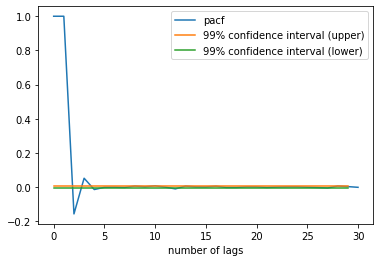

In [19]:
plt.plot(pacf, label='pacf')
plt.plot([2.58/np.sqrt(T)]*30, label='99% confidence interval (upper)')
plt.plot([-2.58/np.sqrt(T)]*30, label='99% confidence interval (lower)')
plt.xlabel('number of lags')
plt.legend()

In [20]:
train_weight = 0.8
split = int(len(df) * train_weight)

df_train = df[use_features].iloc[:split]
df_test = df[use_features].iloc[split:]

array([[<AxesSubplot:title={'center':'USD'}>]], dtype=object)

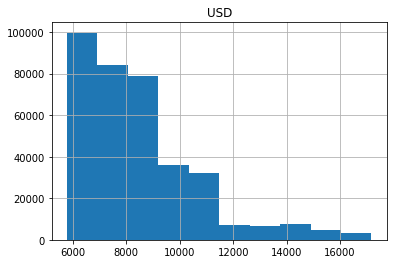

In [21]:
df_train.hist()

<AxesSubplot:xlabel=' timestamp'>

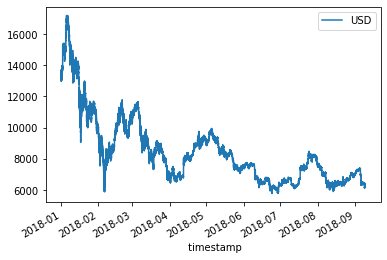

In [22]:
df_train.plot()

# scaling

In [23]:
# note that for a multivariate time series, you would need to scale 
# each variable by its own mean and standard deviation in the training set
mu = np.float64(df_train.mean())
sigma = np.float64(df_train.std())

stdize_input = lambda x: (x - mu) / sigma

df_train = df_train.apply(stdize_input)
df_test = df_test.apply(stdize_input)

<AxesSubplot:xlabel=' timestamp'>

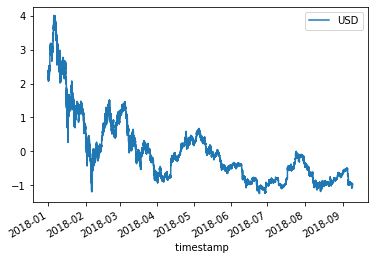

In [17]:
df_train.plot()

array([[<AxesSubplot:title={'center':'target_close'}>]], dtype=object)

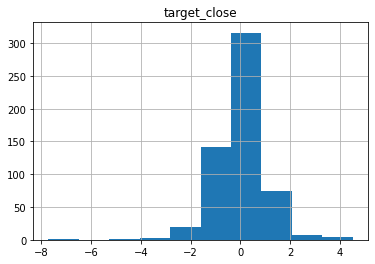

In [178]:
df_train.hist()

In [105]:
# note that for a multivariate time series, you would need to scale 
# each variable by its own mean and standard deviation in the training set
x_min = np.float64(df_train['target_close'].min())
x_max = np.float64(df_train['target_close'].max())

min_max = lambda x: (x - x_min) / (x_max - x_min)

df_train = df_train.apply(min_max)
df_test = df_test.apply(min_max)

array([[<AxesSubplot:title={'center':'target_close'}>]], dtype=object)

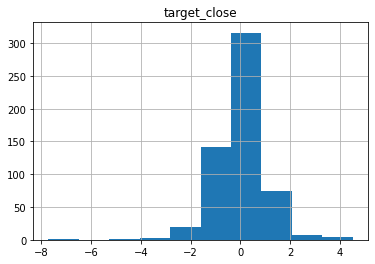

In [179]:
df_train.hist()

In [24]:
def get_lagged_features(df, n_steps, n_steps_ahead):
    """
    df: pandas DataFrame of time series to be lagged
    n_steps: number of lags, i.e. sequence length
    n_steps_ahead: forecasting horizon
    """
    lag_list = []
    
    for lag in range(n_steps + n_steps_ahead - 1, n_steps_ahead - 1, -1):
        lag_list.append(df.shift(lag))
    lag_array = np.dstack([i[n_steps+n_steps_ahead-1:] for i in lag_list])
    # We swap the last two dimensions so each slice along the first dimension
    # is the same shape as the corresponding segment of the input time series 
    lag_array = np.swapaxes(lag_array, 1, -1)
    return lag_array

In [25]:
x_train = get_lagged_features(df_train, n_steps, n_steps_ahead)
y_train =  df_train.values[n_steps + n_steps_ahead - 1:]
y_train_timestamps = df_train.index[n_steps + n_steps_ahead - 1:]

x_test = get_lagged_features(df_test, n_steps, n_steps_ahead)
y_test =  df_test.values[n_steps + n_steps_ahead - 1:]
y_test_timestamps = df_test.index[n_steps + n_steps_ahead - 1:]

In [26]:
print([tensor.shape for tensor in (x_train, y_train, x_test, y_test)])

[(360008, 4, 1), (360008, 1), (89997, 4, 1), (89997, 1)]


In [27]:
def GRU_(n_units = 10, l1_reg=0, seed=0):
  model = Sequential()
  model.add(GRU(n_units, activation='tanh', kernel_initializer=keras.initializers.glorot_uniform(seed), bias_initializer=keras.initializers.glorot_uniform(seed), recurrent_initializer=keras.initializers.orthogonal(seed), kernel_regularizer=l1(l1_reg), input_shape=(x_train.shape[1], x_train.shape[-1]), unroll=True))  
  model.add(Dense(1, kernel_initializer=keras.initializers.glorot_uniform(seed), bias_initializer=keras.initializers.glorot_uniform(seed), kernel_regularizer=l1(l1_reg)))
  model.compile(loss='mean_squared_error', optimizer='adam')
  return model


def LSTM_(n_units = 10, l1_reg=0, seed=0):
  model = Sequential()
  model.add(LSTM(n_units, activation='tanh', kernel_initializer=keras.initializers.glorot_uniform(seed), bias_initializer=keras.initializers.glorot_uniform(seed), recurrent_initializer=keras.initializers.orthogonal(seed), kernel_regularizer=l1(l1_reg), input_shape=(x_train.shape[1], x_train.shape[-1]), unroll=True)) 
  model.add(Dense(1, kernel_initializer=keras.initializers.glorot_uniform(seed), bias_initializer=keras.initializers.glorot_uniform(seed), kernel_regularizer=l1(l1_reg)))
  model.compile(loss='mean_squared_error', optimizer='adam')
  return model

In [47]:
max_epochs = 20
batch_size = 2048

In [43]:
es = EarlyStopping(monitor='loss', mode='min', verbose=1, patience=100, min_delta=1e-7, restore_best_weights=True)

In [44]:
params = {
    'gru': {
        'model': None, 'function':GRU_,'l1_reg': 0.0, 'H': 10, 
        'color': 'orange', 'label': 'GRU'},
    'lstm': {
        'model': None, 'function': LSTM_,'l1_reg': 0.0, 'H': 10, 
        'color':'red', 'label': 'LSTM'}
}

Hyperparameter Tuning (25 mins 43 seconds)

In [48]:
cross_val = True # WARNING: Changing this to True will take many hours to run

if cross_val:
    n_units = [5, 10, 20]
    l1_reg = [0, 0.001, 0.01, 0.1]
    
    # A dictionary containing a list of values to be iterated through
    # for each parameter of the model included in the search
    param_grid = {'n_units': n_units, 'l1_reg': l1_reg}
    
    # In the kth split, TimeSeriesSplit returns first k folds 
    # as training set and the (k+1)th fold as test set.
    tscv = TimeSeriesSplit(n_splits = 5)
    
    # A grid search is performed for each of the models, and the parameter set which
    # performs best over all the cross-validation splits is saved in the `params` dictionary
    for key in params.keys():
        print('Performing cross-validation. Model:', key)
        model = KerasRegressor(model=params[key]['function'], epochs=max_epochs, 
                               batch_size=batch_size, verbose=2, l1_reg=l1_reg, n_units=n_units)
        grid = GridSearchCV(estimator=model, param_grid=param_grid, 
                            cv=tscv, n_jobs=1, verbose=2) # scikeras uses r^2 scoring by default
        grid_result = grid.fit(x_train, y_train, callbacks=[es])
        print("Best: %f using %s" % (grid_result.best_score_, grid_result.best_params_))
        
        means = grid_result.cv_results_['mean_test_score']
        stds = grid_result.cv_results_['std_test_score']
        params_ = grid_result.cv_results_['params']
        for mean, stdev, param_ in zip(means, stds, params_):
            print("%f (%f) with %r" % (mean, stdev, param_))
            
        params[key]['H'] = grid_result.best_params_['n_units']
        params[key]['l1_reg']= grid_result.best_params_['l1_reg']

Performing cross-validation. Model: gru
Fitting 5 folds for each of 12 candidates, totalling 60 fits
Epoch 1/20
30/30 - 1s - loss: 4.1801 - 1s/epoch - 40ms/step
Epoch 2/20
30/30 - 0s - loss: 3.5897 - 487ms/epoch - 16ms/step
Epoch 3/20
30/30 - 0s - loss: 3.0026 - 422ms/epoch - 14ms/step
Epoch 4/20
30/30 - 0s - loss: 2.4780 - 434ms/epoch - 14ms/step
Epoch 5/20
30/30 - 0s - loss: 2.0523 - 497ms/epoch - 17ms/step
Epoch 6/20
30/30 - 0s - loss: 1.7138 - 479ms/epoch - 16ms/step
Epoch 7/20
30/30 - 0s - loss: 1.4390 - 472ms/epoch - 16ms/step
Epoch 8/20
30/30 - 0s - loss: 1.2096 - 400ms/epoch - 13ms/step
Epoch 9/20
30/30 - 0s - loss: 1.0098 - 401ms/epoch - 13ms/step
Epoch 10/20
30/30 - 0s - loss: 0.8317 - 401ms/epoch - 13ms/step
Epoch 11/20
30/30 - 0s - loss: 0.6702 - 456ms/epoch - 15ms/step
Epoch 12/20
30/30 - 0s - loss: 0.5252 - 441ms/epoch - 15ms/step
Epoch 13/20
30/30 - 0s - loss: 0.3996 - 400ms/epoch - 13ms/step
Epoch 14/20
30/30 - 0s - loss: 0.2974 - 406ms/epoch - 14ms/step
Epoch 15/20
30/

KeyboardInterrupt: 

In [ ]:
# Best: 0.998548 using {'l1_reg': 0, 'n_units': 10}
# 0.993083 (0.007258) with {'l1_reg': 0, 'n_units': 5}
# 0.998548 (0.000941) with {'l1_reg': 0, 'n_units': 10}
# 0.998275 (0.001268) with {'l1_reg': 0, 'n_units': 20}
# 0.991056 (0.006129) with {'l1_reg': 0.001, 'n_units': 5}
# 0.996491 (0.001985) with {'l1_reg': 0.001, 'n_units': 10}
# 0.995481 (0.004580) with {'l1_reg': 0.001, 'n_units': 20}
# 0.970067 (0.025808) with {'l1_reg': 0.01, 'n_units': 5}
# 0.953247 (0.057576) with {'l1_reg': 0.01, 'n_units': 10}
# 0.983152 (0.014979) with {'l1_reg': 0.01, 'n_units': 20}
# 0.656916 (0.443510) with {'l1_reg': 0.1, 'n_units': 5}
# 0.776639 (0.209577) with {'l1_reg': 0.1, 'n_units': 10}
# 0.515927 (0.431361) with {'l1_reg': 0.1, 'n_units': 20}

fit model
3 min 35.5 s

In [50]:
print(batch_size)

2048


In [51]:
# 3 min 35.5s
for key in params.keys():
    tf.random.set_seed(0)
    print('Training', key, 'model')
    # params[key]['H'] = best
    #model = params[key]['function'](params[key]['H'], params[key]['l1_reg'])
    model = params[key]['function'](10, 0)
    model.fit(x_train, y_train, epochs=max_epochs, 
                batch_size=batch_size, callbacks=[es], shuffle=False)
    params[key]['model'] = model

Training gru model
Epoch 1/20
176/176 [==============================] - 4s 17ms/step - loss: 2.5023
Epoch 2/20
176/176 [==============================] - 3s 17ms/step - loss: 0.3890
Epoch 3/20
176/176 [==============================] - 3s 17ms/step - loss: 0.1173
Epoch 4/20
176/176 [==============================] - 3s 16ms/step - loss: 0.0430
Epoch 5/20
176/176 [==============================] - 3s 16ms/step - loss: 0.0329
Epoch 6/20
176/176 [==============================] - 3s 15ms/step - loss: 0.0261
Epoch 7/20
176/176 [==============================] - 3s 15ms/step - loss: 0.0209
Epoch 8/20
176/176 [==============================] - 3s 14ms/step - loss: 0.0169
Epoch 9/20
176/176 [==============================] - 3s 15ms/step - loss: 0.0139
Epoch 10/20
176/176 [==============================] - 3s 15ms/step - loss: 0.0117
Epoch 11/20
176/176 [==============================] - 3s 15ms/step - loss: 0.0100
Epoch 12/20
176/176 [==============================] - 2s 14ms/step - loss: 0

Make predictions
2 min 54.9s 

In [52]:
for key in params.keys():
    model = params[key]['model']
    model.summary()
    
    params[key]['pred_train'] = model.predict(x_train, verbose=1)
    params[key]['MSE_train'] = mean_squared_error(y_train, params[key]['pred_train'])
    
    params[key]['pred_test'] = model.predict(x_test, verbose=1) 
    params[key]['MSE_test'] = mean_squared_error(y_test, params[key]['pred_test'])

Model: "sequential_74"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 gru_68 (GRU)                (None, 10)                390       
                                                                 
 dense_74 (Dense)            (None, 1)                 11        
                                                                 
Total params: 401
Trainable params: 401
Non-trainable params: 0
_________________________________________________________________
2813/2813 [==============================] - 18s 6ms/step
Model: "sequential_75"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_6 (LSTM)               (None, 10)                480       
                                                                 
 dense_75 (Dense)            (None, 1)                 11        
                                        

In [53]:
print('training set:', len(y_train))
print('testing set:', len(y_test))

# Upper limits for `l` & `u` in the cells below:

training set: 360008
testing set: 89997


In [54]:
print(params.keys())

# Set `compare` in the cells below to a list
# containing any subset of these:

dict_keys(['gru', 'lstm'])


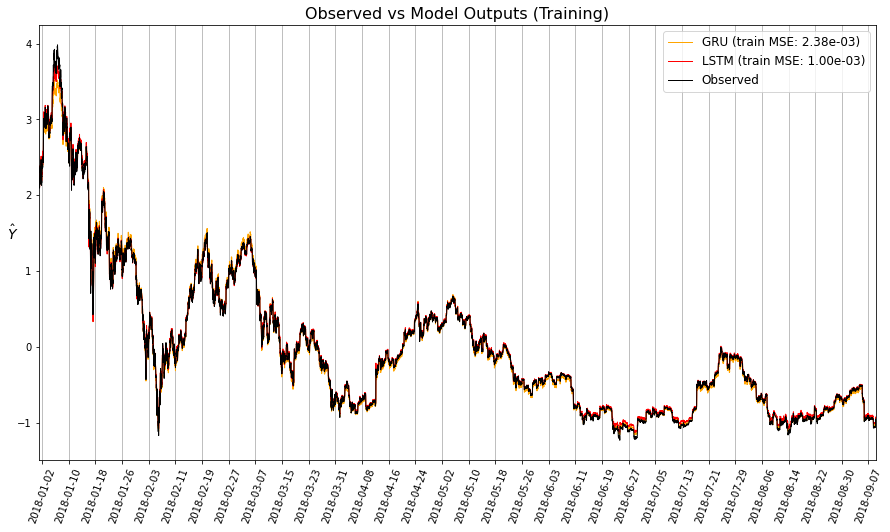

In [55]:
max_pts = 10**4
compare = ['gru', 'lstm'] # e.g. ['rnn', 'alpharnn'] or ['lstm']
l, u = (None, None) # lower and upper indices of range to plot 
ds = max(1, len(y_train[l:u])//max_pts) # Downsampling ratio for under `max_pts`
                                        # per series.  Set `None` to disable. 

fig = plt.figure(figsize=(15,8))
x_vals = y_train_timestamps[l:u:ds]
for key in compare:
    y_vals = params[key]['pred_train'][l:u:ds]
    label = params[key]['label'] + ' (train MSE: %.2e)' % params[key]['MSE_train']
    plt.plot(x_vals, y_vals, c=params[key]['color'], label=label, lw=1)
plt.plot(x_vals, y_train[l:u:ds], c="black", label="Observed", lw=1)
start, end = x_vals.min(), x_vals.max()
xticks =  [start.date() + timedelta(days=(1+i)) for i in range(1 + (end - start).days)]
xticks = xticks[::max(1, len(xticks)//30)]
for t in xticks: plt.axvline(x=t, c='gray', linewidth=0.5, zorder=0)
plt.xticks(xticks, rotation=70)
plt.xlim(start, end)
plt.ylabel('$\hat{Y}$', rotation=0, fontsize=14)
plt.legend(loc="best", fontsize=12)
plt.title('Observed vs Model Outputs (Training)', fontsize=16);

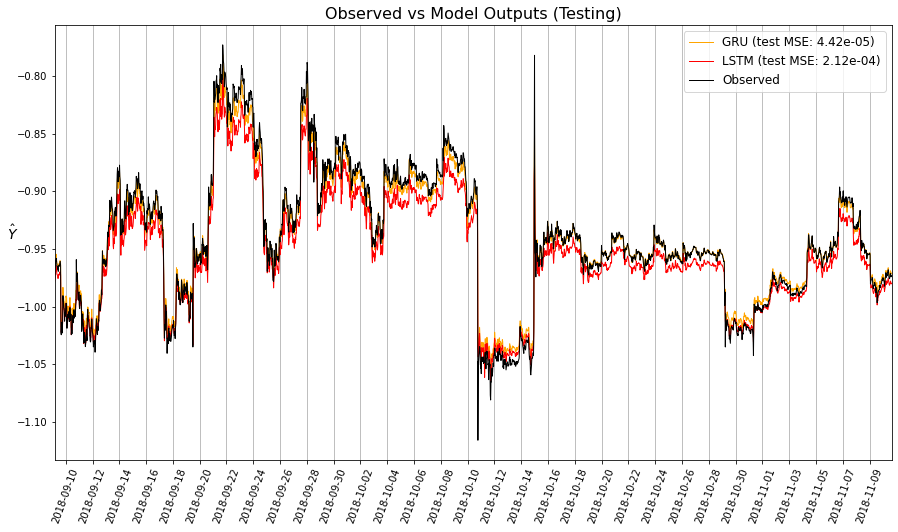

In [39]:
compare = ['gru', 'lstm'] # e.g. ['rnn', 'alpharnn'] or ['lstm']
l, u = (None, None) # lower and upper indices of range to plot 
ds = max(1, len(y_train[l:u])//max_pts) # Downsampling ratio for under `max_pts`
                                        # per series.  Set `None` to disable.
fig = plt.figure(figsize=(15,8))
x_vals = y_test_timestamps[l:u:ds]
for key in compare:
    y_vals = params[key]['pred_test'][l:u:ds]
    label = params[key]['label'] + ' (test MSE: %.2e)' % params[key]['MSE_test']
    plt.plot(x_vals, y_vals, c=params[key]['color'], label=label, lw=1)
plt.plot(x_vals, y_test[l:u:ds], c="black", label="Observed", lw=1)
start, end = x_vals.min(), x_vals.max()
xticks =  [start.date() + timedelta(days=(1+i)) for i in range(1 + (end - start).days)]
xticks = xticks[::max(1, len(xticks)//30)]
for t in xticks: plt.axvline(x=t, c='gray', linewidth=0.5, zorder=0)
plt.xticks(xticks, rotation=70)
plt.xlim(start, end)
plt.ylabel('$\hat{Y}$', rotation=0, fontsize=14)
plt.legend(loc="best", fontsize=12)
plt.title('Observed vs Model Outputs (Testing)', fontsize=16);

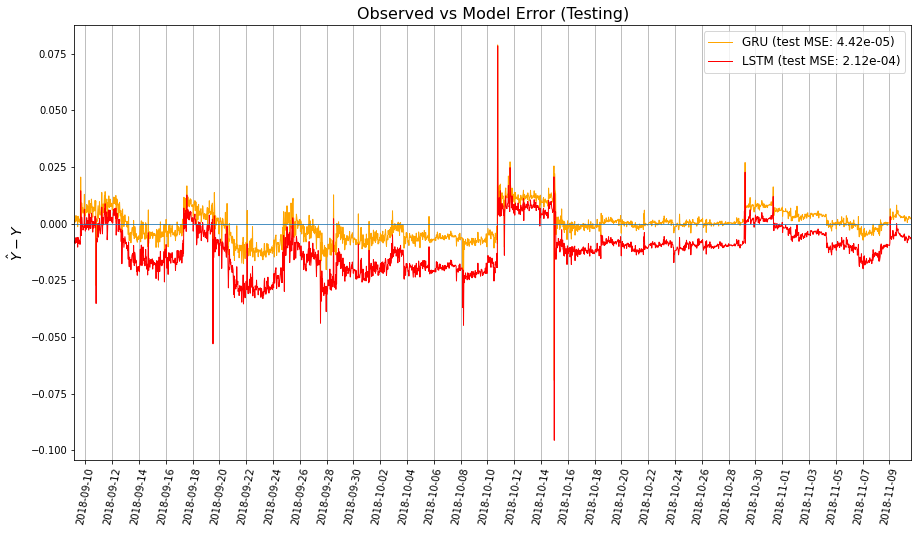

In [40]:
compare = ['gru', 'lstm'] # e.g. ['rnn', 'alpharnn'] or ['lstm']
l, u = (None, None) # e.g. (None, 100000) lower and upper indices of range to plot 
ds = max(1, len(y_train[l:u])//max_pts) # Downsampling ratio for under `max_pts`
                                        # per series.  Set `None` to disable.
fig = plt.figure(figsize=(15,8))
x_vals = y_test_timestamps[l:u:ds]
for key in compare:
    y_vals = params[key]['pred_test'][l:u:ds] - y_test[l:u:ds]
    label = params[key]['label'] + ' (test MSE: %.2e)' % params[key]['MSE_test']
    plt.plot(x_vals, y_vals, c=params[key]['color'], label=label, lw=1)
start, end = x_vals.min(), x_vals.max()
xticks =  [start.date() + timedelta(days=(1+i)) for i in range(1 + (end - start).days)]
xticks = xticks[::max(1, len(xticks)//30)]
plt.axhline(0, linewidth=0.8)
for t in xticks: plt.axvline(x=t, c='gray', linewidth=0.5, zorder=0)
plt.xticks(xticks, rotation=80)
plt.xlim(start, end)
plt.ylabel('$\hat{Y}-Y$', fontsize=14)
plt.legend(loc="best", fontsize=12)
plt.title('Observed vs Model Error (Testing)', fontsize=16);

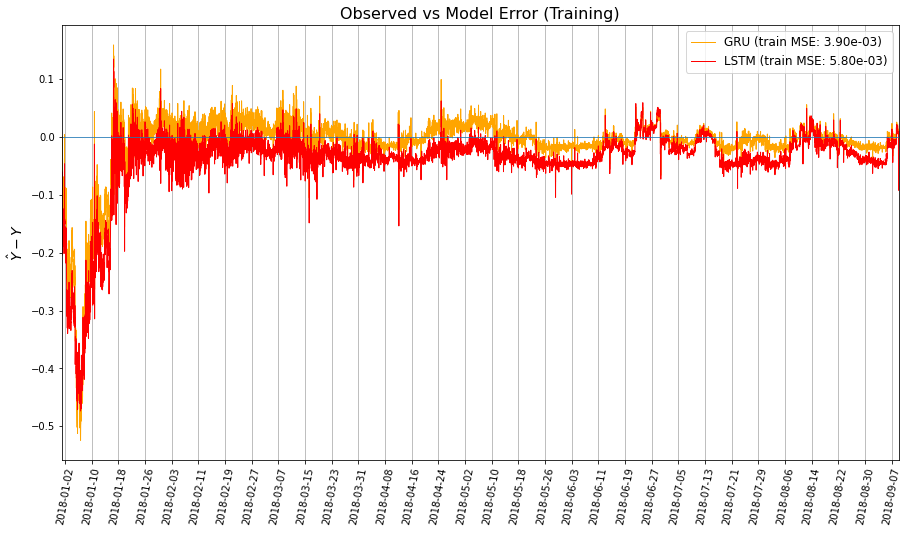

In [41]:
compare = ['gru', 'lstm'] # e.g. ['rnn', 'alpharnn'] or ['lstm']
l, u = (None, None) # lower and upper indices of range to plot - e.g. (None, 10000)
ds = max(1, len(y_train[l:u])//max_pts) # Downsampling ratio for under `max_pts`
                                        # per series.  Set `None` to disable.
fig = plt.figure(figsize=(15,8))
x_vals = y_train_timestamps[l:u:ds]
for key in compare:
    y_vals = params[key]['pred_train'][l:u:ds] - y_train[l:u:ds]
    label = params[key]['label'] + ' (train MSE: %.2e)' % params[key]['MSE_train']
    plt.plot(x_vals, y_vals, c=params[key]['color'], label=label, lw=1)
start, end = x_vals.min(), x_vals.max()
xticks =  [start.date() + timedelta(days=(1+i)) for i in range(1 + (end - start).days)]
xticks = xticks[::max(1, len(xticks)//30)]
plt.axhline(0, linewidth=0.8)
for t in xticks: plt.axvline(x=t, c='gray', linewidth=0.5, zorder=0)
plt.xticks(xticks, rotation=80)
plt.xlim(start, end)
plt.ylabel('$\hat{Y}-Y$', fontsize=14)
plt.legend(loc="best", fontsize=12)
plt.title('Observed vs Model Error (Training)', fontsize=16);